In [5]:
# Importing libraries
import pymc as pm
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
import scipy as sp
from scipy.stats import t
import matplotlib.pyplot as plt
import arviz as az
from arviz import plot_trace
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
import warnings
import warnings

# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
# Read the CSV file into a DataFrame. 
# Data is monthly, so we resample to quarterly, to obtain lagged values and later predict probabilities of S&P 500 within a predefined return range
df = pd.read_csv('resources/data.csv', usecols=['Date','S&P500','VIX','Interest Rates'], parse_dates=['Date'])
df = df.set_index('Date')
df = df.rename(columns={'S&P500': 'sp500', 'Interest Rates': 'interest_rates'})
df = df.resample('QS').last()
# Print the first few rows of the DataFrame
df.head()

,interest_rates,sp500,VIX
Date,,,
2000-01-01,5.85,1498.579956,24.110001
2000-04-01,6.53,1454.599976,19.540001
2000-07-01,6.52,1436.510010,20.570000
2000-10-01,6.40,1320.280029,26.850000
2001-01-01,5.31,1160.329956,28.639999


In [7]:
# Calculate Logarithmic Returns for S&P 500
df['sp_returns'] = np.log(df['sp500']).diff()
df['VIX_change'] = np.log(df['VIX']).diff()
df['interest_rates_change'] = df['interest_rates'].diff()
df = df.dropna()

In [8]:
# Create lagged features (adjust lag orders as needed)
df['sp_returns_lag1'] = df['sp_returns'].shift(1)
df['VIX_lag1'] = df['VIX_change'].shift(1)
df['interest_rates_lag1'] = df['interest_rates_change'].shift(1)
df = df.dropna()

In [9]:
# Select features. Experiment with feature engineering.
#features = ['sp_returns_lag1', 'VIX_lag1', 'VIX', 'interest_rates', 'sp_returns_lag1*VIX']
features = ['VIX_lag1', 'interest_rates_lag1', 'sp_returns_lag1']

In [10]:
# Time-based train/test split (using data up to 2021 for training)
train_end_year = 2022
train_data = df.loc[df.index.year <= train_end_year]
test_data = df.loc[df.index.year > train_end_year]

X_train = train_data[features].dropna()
y_train = train_data['sp_returns'] 

X_test = test_data[features].dropna()
y_test = test_data['sp_returns'] 

# Standardize features using RobustScaler because of potential outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Initialize a list to store the predicted probabilities
predicted_probs = []

# For each quarter in the test set
for i in range(len(X_test)):
    # Fit the PyMC model
    with pm.Model() as model:
        # Define the prior distributions for the model parameters
        alpha = pm.Normal('alpha', mu=0, sigma=10)
        beta_vix = pm.Normal('beta_vix', mu=0, sigma=5)
        beta_rates = pm.Normal('beta_rates', mu=0, sigma=5)
        beta_sp = pm.Normal('beta_sp', mu=0, sigma=5)
        sigma = pm.HalfNormal('sigma', sigma=5)
        nu = pm.Exponential('nu', lam=1/30)

        # Create a shared variable for your input data, making it mutable for updates
        X_shared = pm.MutableData('X_shared', X_train_scaled)
        y_shared = pm.MutableData('y_shared', y_train)  # Make y_train mutable

        # Define the likelihood function for the observed data
        returns = pm.StudentT('sp_returns',
                              nu=nu,
                              mu=alpha + beta_vix * X_shared[:, 0] + beta_rates * X_shared[:, 1] + beta_sp * X_shared[:, 2],
                              sigma=sigma,
                              observed=y_shared)

        # Perform Markov chain Monte Carlo (MCMC) sampling
        trace = pm.sample(draws=10000, tune=2000, target_accept=0.90)
    
    # Perform posterior predictive sampling to generate samples of the model's predictions
    with model:
        post_pred = pm.sample_posterior_predictive(
            trace=trace, 
            model=model, 
            var_names=['sp_returns'],  # Specify variable names to generate predictions for
            random_seed=42,  # For reproducibility, optional
            progressbar=True,  # Show progress bar, optional
            return_inferencedata=True  # Returns an InferenceData object
        )

    # Inspect the posterior predictive samples
    posterior_returns = post_pred.posterior_predictive['sp_returns'].values

    # Calculate the mean log returns of the posterior predictive returns
    mean_log_returns = np.mean(posterior_returns, axis=(0, 1))

    # Calculate the standard deviation of log returns of the posterior predictive returns
    std_returns = np.std(posterior_returns, axis=(0, 1))

    # Convert mean log returns to percentage returns for interpretation
    percentage_returns = (np.exp(mean_log_returns) - 1) * 100

    # Extract degrees of freedom from the trace (use the mean value for simplicity)
    df = np.mean(trace.posterior['nu'].values)

    # Calculate probabilities using the Student's t-distribution for illustrative ranges
    prob_0_to_5 = np.mean([t.cdf(0.05, df, loc=mean, scale=std) - t.cdf(0, df, loc=mean, scale=std)
                           for mean, std in zip(mean_log_returns, std_returns)])
    prob_0_to_neg5 = np.mean([t.cdf(0, df, loc=mean, scale=std) - t.cdf(-0.05, df, loc=mean, scale=std)
                              for mean, std in zip(mean_log_returns, std_returns)])
    prob_above_5 = np.mean([1 - t.cdf(0.05, df, loc=mean, scale=std)
                            for mean, std in zip(mean_log_returns, std_returns)])
    prob_below_neg5 = np.mean([t.cdf(-0.05, df, loc=mean, scale=std)
                               for mean, std in zip(mean_log_returns, std_returns)])

    # Store the predicted probabilities
    predicted_probs.append((prob_0_to_5, prob_0_to_neg5, prob_above_5, prob_below_neg5))
    
    # Add the actual returns for the current quarter to the training data
    X_train = np.concatenate([X_train, X_test[i:i+1]])
    y_train = np.concatenate([y_train, y_test[i:i+1]])

    # Rescale the new training data
    X_train_scaled = scaler.transform(X_train)

    # Check if X_train and y_train have the same length
    assert len(X_train) == len(y_train), "Lengths of X_train and y_train must be equal."

    # Update the model's input data with the new X_train and y_train
    with model:
        pm.set_data({'X_shared': X_train, 'y_shared': y_train})  # Update y_shared instead of sp_returns
# `predicted_probs` now contains the predicted probabilities for each quarter in the test set

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_vix, beta_rates, beta_sp, sigma, nu]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 45 seconds.
Sampling: [sp_returns]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_vix, beta_rates, beta_sp, sigma, nu]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 45 seconds.
Sampling: [sp_returns]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_vix, beta_rates, beta_sp, sigma, nu]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 46 seconds.
Sampling: [sp_returns]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_vix, beta_rates, beta_sp, sigma, nu]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 49 seconds.
Sampling: [sp_returns]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_vix, beta_rates, beta_sp, sigma, nu]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 49 seconds.
Sampling: [sp_returns]


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta_vix'}>,
        <Axes: title={'center': 'beta_vix'}>],
       [<Axes: title={'center': 'beta_rates'}>,
        <Axes: title={'center': 'beta_rates'}>],
       [<Axes: title={'center': 'beta_sp'}>,
        <Axes: title={'center': 'beta_sp'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>]],
      dtype=object)

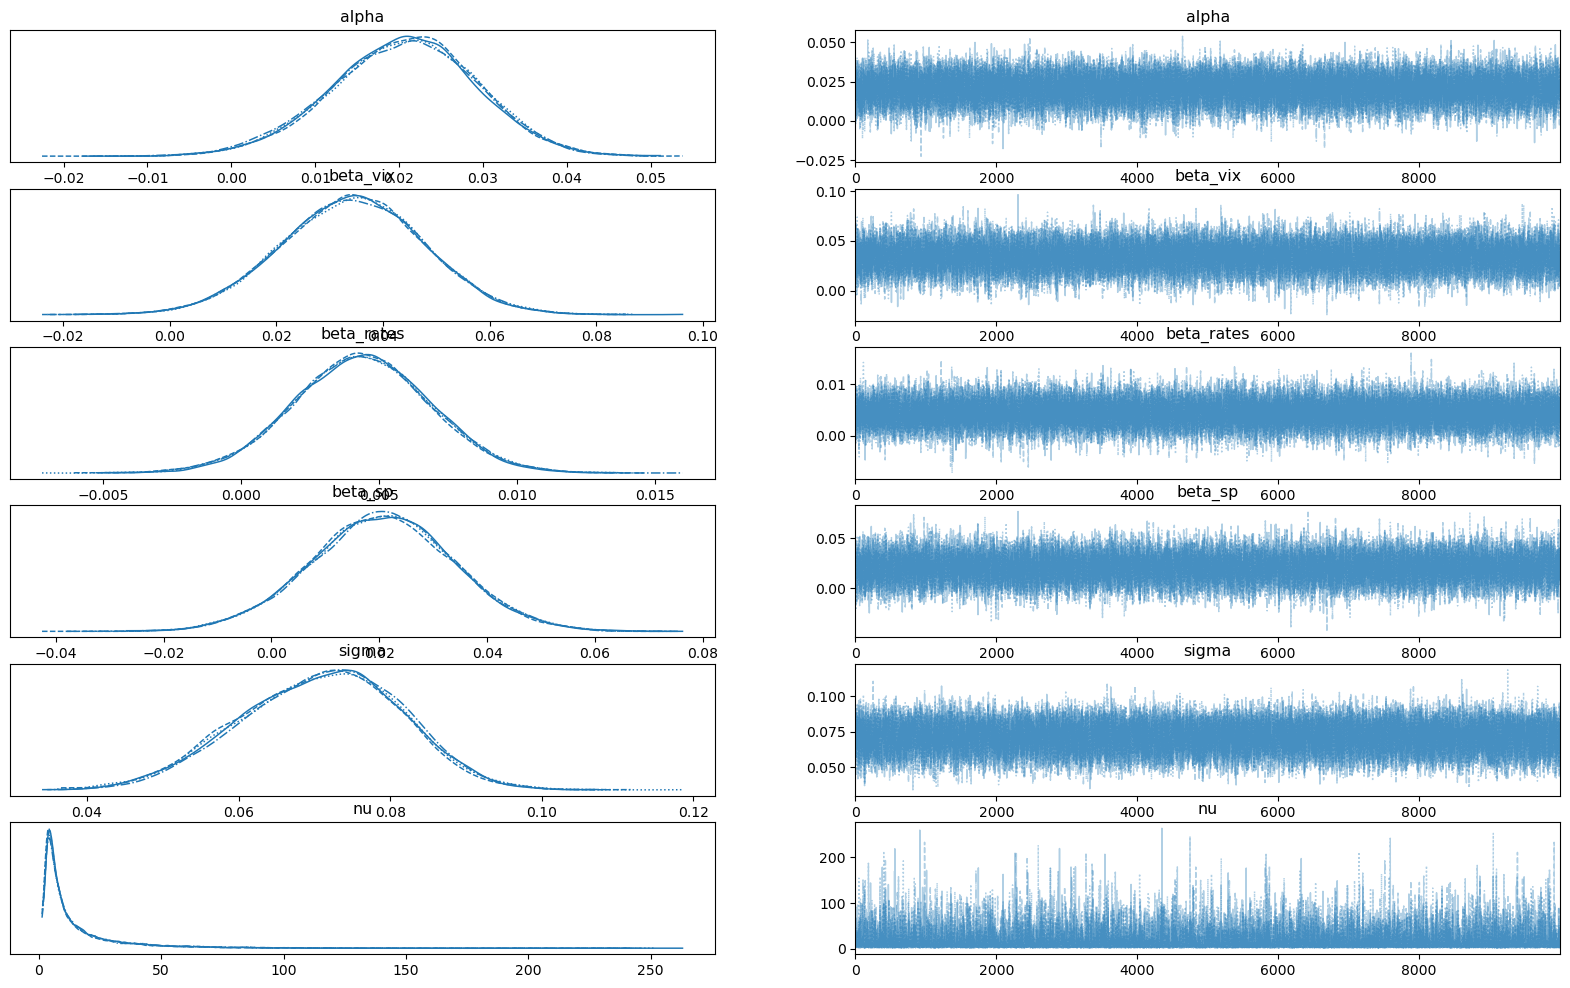

In [19]:
# Plot the trace of the MCMC samples. 
# This plot shows the values sampled for each parameter over the course of the sampling process.
# The goal is to see good mixing and convergence of the samples.
az.plot_trace(trace, figsize=(20, 12)) 

In [20]:
# Summarize the posterior distribution of the model parameters
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.021,0.009,0.004,0.037,0.00,0.000,26175.0,27677.0,1.0
beta_vix,0.034,0.013,0.009,0.059,0.00,0.000,21534.0,25652.0,1.0
beta_rates,0.004,0.002,-0.000,0.009,0.00,0.000,33910.0,29141.0,1.0
beta_sp,0.021,0.013,-0.005,0.046,0.00,0.000,20045.0,23602.0,1.0
sigma,0.071,0.010,0.051,0.090,0.00,0.000,17837.0,21184.0,1.0
nu,15.493,19.975,1.194,49.631,0.13,0.092,17697.0,24813.0,1.0


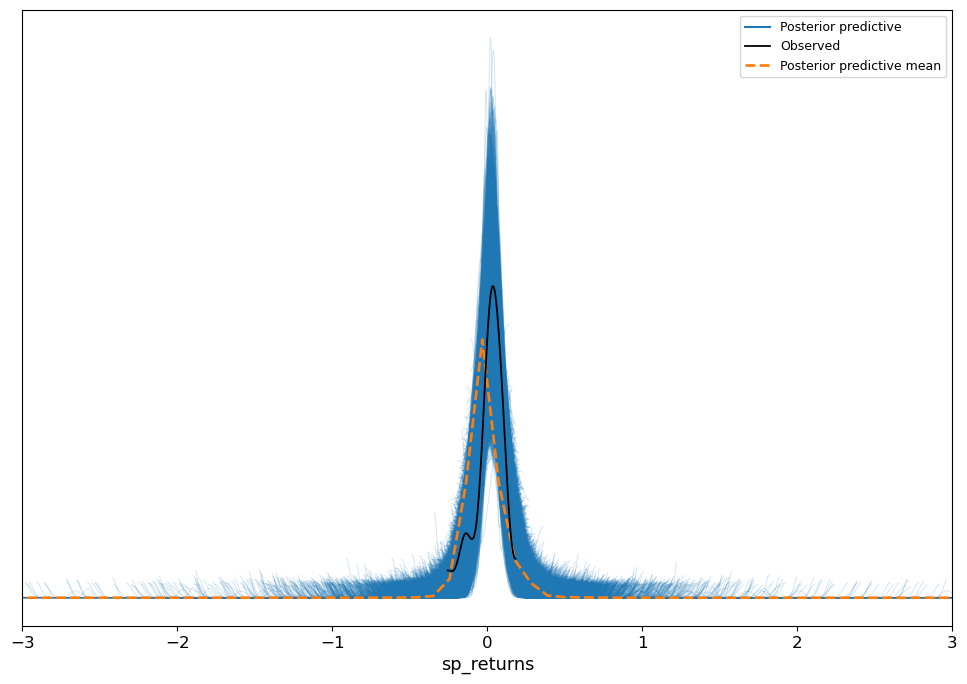

In [21]:
# Plot the posterior predictive distribution of S&P 500 returns
ax = az.plot_ppc(post_pred, group='posterior', data_pairs={'sp_returns': 'sp_returns'},figsize=(12, 8), mean=True, kind='kde', textsize=12)
ax.set_xlim(-3,3)
plt.show()

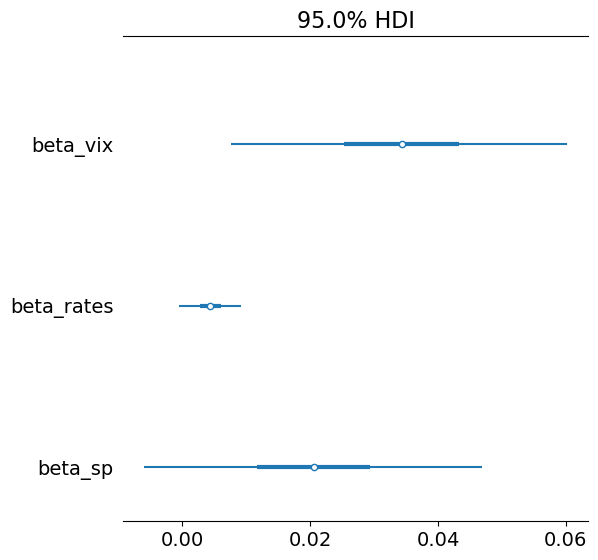

In [22]:
# Plot the posterior distribution of the model parameters
# The plot_forest function provides a visual summary of the posterior distribution of the model parameters
# Values of the model parameters are positive and not inclusive of zero, indicating that they are likely to have an effect on the outcome
az.plot_forest(trace, var_names=['beta_vix', 'beta_rates', 'beta_sp'], combined=True, hdi_prob=0.95)
plt.show()

In [23]:
# Convert the list of predicted probabilities to a DataFrame
predicted_probs_df = pd.DataFrame(predicted_probs, columns=['prob_0_to_5', 'prob_0_to_neg5', 'prob_above_5', 'prob_below_neg5'])

# Reset the index of y_test to match the index of predicted_probs_df
y_test_reset = y_test.reset_index(drop=True)

# Concatenate the predicted probabilities and the actual returns into a single DataFrame
results_df = pd.concat([predicted_probs_df, y_test_reset], axis=1)

# Convert log returns to simple returns
results_df['sp_returns'] = np.exp(results_df['sp_returns']) - 1

# Display the results
results_df

,prob_0_to_5,prob_0_to_neg5,prob_above_5,prob_below_neg5,sp_returns
0,0.197217,0.179703,0.370379,0.252701,0.070272
1,0.197314,0.178743,0.373752,0.250191,0.082999
2,0.199559,0.178903,0.376849,0.244690,-0.036476
3,0.201201,0.181011,0.372726,0.245062,0.112354
4,0.198687,0.178171,0.378667,0.244475,0.068438


In [24]:
# Reset the index of y_test to get the dates
y_test_reset = y_test.reset_index()

# Rename the 'index' column to 'Date'
y_test_reset = y_test_reset.rename(columns={'index': 'Date'})

# Concatenate the predicted probabilities, the actual returns, and the dates into a single DataFrame
results_df = pd.concat([predicted_probs_df, y_test_reset], axis=1)

# Convert log returns to simple returns
results_df['sp_returns'] = np.exp(results_df['sp_returns']) - 1

# Display the results
results_df = results_df.set_index('Date')  # Set the 'Date' column as the index
results_df

,prob_0_to_5,prob_0_to_neg5,prob_above_5,prob_below_neg5,sp_returns
Date,,,,,
2023-01-01,0.197217,0.179703,0.370379,0.252701,0.070272
2023-04-01,0.197314,0.178743,0.373752,0.250191,0.082999
2023-07-01,0.199559,0.178903,0.376849,0.244690,-0.036476
2023-10-01,0.201201,0.181011,0.372726,0.245062,0.112354
2024-01-01,0.198687,0.178171,0.378667,0.244475,0.068438


In [25]:
# Define a function to assign the prediction based on the highest probability
def assign_prediction(row):
    # Get the column name of the highest probability
    highest_prob_col = row[['prob_0_to_5', 'prob_0_to_neg5', 'prob_above_5', 'prob_below_neg5']].idxmax()

    # Check if the actual return falls within the range of the highest predicted probability
    if highest_prob_col == 'prob_0_to_5' and 0 <= row['sp_returns'] <= 0.05:
        return 1
    elif highest_prob_col == 'prob_0_to_neg5' and -0.05 <= row['sp_returns'] < 0:
        return 1
    elif highest_prob_col == 'prob_above_5' and row['sp_returns'] > 0.05:
        return 1
    elif highest_prob_col == 'prob_below_neg5' and row['sp_returns'] < -0.05:
        return 1
    else:
        return 0

# Apply the function to each row in the DataFrame
results_df['prediction'] = results_df.apply(assign_prediction, axis=1)
results_df

,prob_0_to_5,prob_0_to_neg5,prob_above_5,prob_below_neg5,sp_returns,prediction
Date,,,,,,
2023-01-01,0.197217,0.179703,0.370379,0.252701,0.070272,1
2023-04-01,0.197314,0.178743,0.373752,0.250191,0.082999,1
2023-07-01,0.199559,0.178903,0.376849,0.244690,-0.036476,0
2023-10-01,0.201201,0.181011,0.372726,0.245062,0.112354,1
2024-01-01,0.198687,0.178171,0.378667,0.244475,0.068438,1
